## Problem 1: The Jacobi Method

In [1]:
import numpy as np
from scipy import linalg as la

In [2]:
def jacobi(A,b,tol=1e-6,maxiters=1e5):
    d = np.diag(A).reshape((len(b),1))
    numiters = 1
    diff = 1
    xguess = np.zeros(len(b)).reshape((len(b),1))
    
    while diff > tol and numiters < maxiters:
        xupdate = xguess + (b - A @ xguess) / d
        diff = la.norm(xupdate-xguess,np.inf)
        numiters += 1
        xguess = xupdate
    
    return xupdate

In [3]:
def diag_dom(n, num_entries=None):
    """Generate a strictly diagonally dominant (n, n) matrix.
    Parameters:
    n (int): The dimension of the system.
    num_entries (int): The number of nonzero values.
    Defaults to n^(3/2)-n.
    Returns:
    A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    """
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

In [4]:
A = diag_dom(10)
b = np.random.random((10,1))
print(la.solve(A, b))
print(jacobi(A,b))

[[0.20854065]
 [0.06234033]
 [0.13838823]
 [0.14767201]
 [0.11337025]
 [0.2120212 ]
 [0.27005165]
 [0.20627225]
 [0.01561609]
 [0.06907012]]
[[0.20854121]
 [0.06233978]
 [0.13838813]
 [0.14767174]
 [0.11336983]
 [0.21202155]
 [0.27005137]
 [0.20627246]
 [0.01561622]
 [0.06907032]]


## Problem 2

In [5]:
from matplotlib import pyplot as plt

In [6]:
def jacobi_new(A,b,tol=1e-6,maxiters=1e5,plot=False):
    d = np.diag(A).reshape((len(b),1))
    numiters = 1
    diff = 1
    xguess = np.zeros(len(b)).reshape((len(b),1))
    abserr = []
    
    while diff > tol and numiters < maxiters:
        xupdate = xguess + (b - A @ xguess) / d
        abserr.append(la.norm(A @ xupdate - b, np.inf))
        diff = la.norm(xupdate-xguess,np.inf)
        numiters += 1
        xguess = xupdate     
        
    if plot == True:
        plt.semilogy(np.arange(1, numiters, 1), abserr)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Jacobi Method')     
    
    return xupdate

array([[0.20854121],
       [0.06233978],
       [0.13838813],
       [0.14767174],
       [0.11336983],
       [0.21202155],
       [0.27005137],
       [0.20627246],
       [0.01561622],
       [0.06907032]])

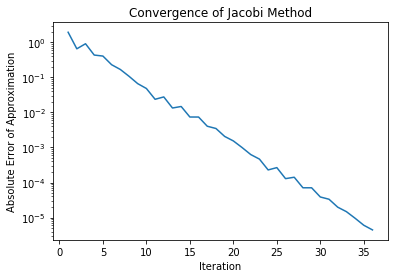

In [7]:
jacobi_new(A,b,plot=True)

## Problem 3: The Gauss-Seidel Method 

In [8]:
def gauss_seidel(A,b,tol=1e-6,maxiters=1e5,plot=False):
    numiters = 1
    diff = 1
    xguess = np.zeros(len(b)).reshape((len(b),1))
    xupdate = np.zeros(len(b)).reshape((len(b),1))
    abserr = []
    
    while diff > tol and numiters < maxiters:
        xold = np.copy(xguess)
        for i in range(len(b)):
            xupdate[i] = xguess[i] + (b[i] - np.dot(A[i,:],xguess)) / A[i,i]
        abserr.append(la.norm(A @ xupdate - b, np.inf))
        diff = la.norm(xupdate-xold,np.inf)
        numiters += 1
        xguess = xupdate
    
    if plot == True:
        plt.semilogy(np.arange(1, numiters, 1), abserr)
        plt.xlabel('Iteration')
        plt.ylabel('Absolute Error of Approximation')
        plt.title('Convergence of Jacobi Method')     
    
    return xupdate

array([[0.20854075],
       [0.06234013],
       [0.13838828],
       [0.14767209],
       [0.11337009],
       [0.21202103],
       [0.27005168],
       [0.2062723 ],
       [0.01561608],
       [0.06907001]])

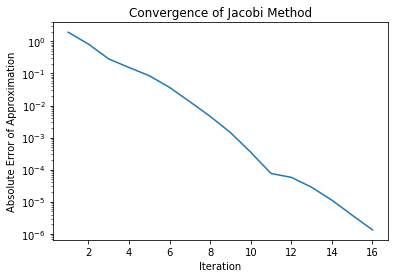

In [9]:
gauss_seidel(A,b,plot=True)

## Problem 4: Solving Sparse Systems Iteratively

In [10]:
from scipy import sparse

In [11]:
def gauss_seidel_sparse(A,b,tol=1e-6,maxiters=1e5):
    numiters = 1
    diff = 1
    xguess = np.zeros(len(b)).reshape((len(b),1))
    xupdate = np.zeros(len(b)).reshape((len(b),1))
    
    while diff > tol and numiters < maxiters:
        xold = np.copy(xguess)
        for i in range(len(b)):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix = A.data[rowstart:rowend] @ xguess[A.indices[rowstart:rowend]]
            xupdate[i] = xguess[i] + (b[i] - Aix) / A[i,i]
        diff = la.norm(xupdate-xold,np.inf)
        numiters += 1
        xguess = xupdate 
    
    return xupdate

In [12]:
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)
gauss_seidel_sparse(A,b)

array([[0.00273255],
       [0.00627977],
       [0.00815573],
       ...,
       [0.0053559 ],
       [0.00398343],
       [0.00860627]])

## Problem 5: Successive Over-Relaxation

In [13]:
def sor(A,b,omega,tol=1e-6,maxiters=1e5):
    numiters = 1
    diff = 1
    xguess = np.zeros(len(b)).reshape((len(b),1))
    xupdate = np.zeros(len(b)).reshape((len(b),1))
    A = A.tocsr()
    
    while diff > tol and numiters < maxiters:
        xold = np.copy(xguess)
        for i in range(len(b)):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            Aix = np.dot(A.data[rowstart:rowend].reshape(-1),xguess[A.indices[rowstart:rowend]].reshape(-1))
            xupdate[i] = xguess[i] + omega * (b[i] - Aix) / A[i,i]
        diff = la.norm(xupdate-xold,np.inf)
        numiters += 1
        xguess = xupdate 
    
    return xupdate,numiters

In [14]:
sor(A,b,0.8)

(array([[0.00273242],
        [0.00627953],
        [0.0081556 ],
        ...,
        [0.00535589],
        [0.00398343],
        [0.00860624]]), 11)

## Problem 6: A Finite Difference Method

In [15]:
def findiff(n,omega,tol=1e-8,maxiters=100,plot=False):
    # matrices inputs
    bsub = np.zeros(n)
    bsub[0] = -100
    bsub[-1] = -100
    b = np.tile(bsub,n)
    
    I = sparse.diags([1], shape=(n,n))
    B = sparse.diags([1,-4,1], [-1,0,1], shape=(n,n))
    Amat = []
    for i in range(n):
        Arow = []
        for j in range(n):
            if j < i - 1:
                Arow.append(None)
            elif j == i - 1:
                Arow.append(I)
            elif j == i:
                Arow.append(B)
            elif j == i + 1:
                Arow.append(I)
            else:
                Arow.append(None)
        Amat.append(Arow)
    A = sparse.bmat(Amat, format='bsr')
    
    u,numiters = sor(A,b,omega,tol,maxiters)

    if plot == True:   
        xax = np.linspace(0, 1, n + 1)
        yax = np.linspace(0, 1, n + 1)
        X, Y = np.meshgrid(xax, yax)
        u2d = u.reshape((n,n))
        fig = plt.figure(figsize=(8,8))
        plt.pcolormesh(X, Y, u2d, cmap='coolwarm')
        plt.colorbar()
        plt.show()
        
    return u,numiters

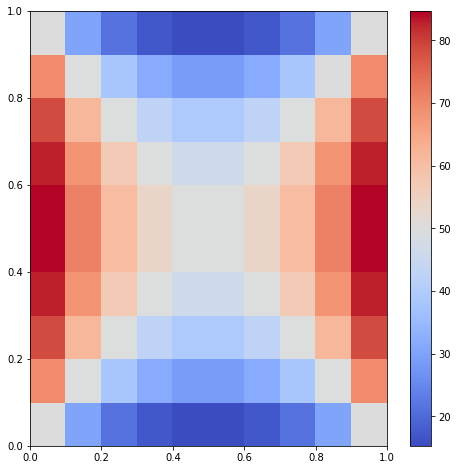

(array([[49.99999998],
        [30.36165215],
        [21.4466087 ],
        [17.12591632],
        [15.30819969],
        [15.3081997 ],
        [17.12591632],
        [21.44660871],
        [30.36165216],
        [49.99999999],
        [69.63834778],
        [49.99999994],
        [38.29886635],
        [31.74885688],
        [28.79868278],
        [28.79868278],
        [31.74885689],
        [38.29886636],
        [49.99999995],
        [69.63834779],
        [78.55339121],
        [61.70113349],
        [49.99999989],
        [42.77196209],
        [39.33899177],
        [39.33899178],
        [42.7719621 ],
        [49.9999999 ],
        [61.7011335 ],
        [78.55339122],
        [82.87408358],
        [68.25114293],
        [57.22803765],
        [49.99999985],
        [46.44633047],
        [46.44633048],
        [49.99999986],
        [57.22803766],
        [68.25114295],
        [82.87408359],
        [84.6918002 ],
        [71.20131702],
        [60.66100795],
        [53

In [16]:
findiff(10,0.8,maxiters = 10000,plot=True)

## Problem 7

In [17]:
n = 20
w = np.arange(1,2,0.05)
numiters = np.zeros(len(w))
for ind,omega in enumerate(w):
    numiters[ind] = findiff(n,omega,tol=1e-2,maxiters=1000,plot=False)[1]

In [18]:
w[np.argmin(numiters)]

1.7500000000000007

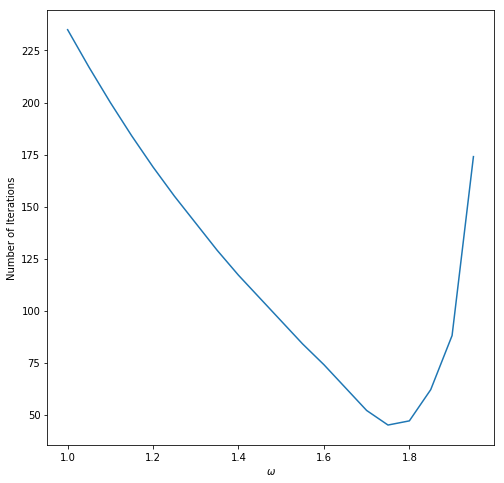

In [19]:
fig = plt.figure(figsize=(8,8))
plt.plot(w, numiters)
plt.xlabel(r'$\omega$')
plt.ylabel('Number of Iterations')
plt.show()